Import Libraries

In [147]:
import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt
import timedelta as td
from scipy.optimize import minimize
import matplotlib.pyplot as plt
#from pandas_datareader import data as pdr

Declare the Date Range for Our Stock Returns

In [148]:
#set today as endDate
endDate = dt.datetime.now()

#let the startDate be 5 years ago
startDate = endDate - dt.timedelta(days = 365 * 5)
endDate, startDate

(datetime.datetime(2024, 12, 24, 1, 59, 11, 530618),
 datetime.datetime(2019, 12, 26, 1, 59, 11, 530618))

Create a Lists of Stocks (Tickers)

In [149]:
tickers = ['NVDA', 'WMT', 'MSFT', 'GOOGL']

Download stock data from yfinance

In [150]:
tickers = ['NVDA', 'WMT', 'MSFT', 'GOOGL']

close_price = pd.DataFrame()
for ticker in tickers:
    df = yf.download(ticker, start = startDate, end = endDate)
    close_price [ticker] = df['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Calculate Daily Log Returns

In [151]:
log_returns = np.log(close_price/close_price.shift(1))
log_returns.tail()

,NVDA,WMT,MSFT,GOOGL
Date,,,,
2024-12-17,-0.012272,0.005781,0.006335,-0.006325
2024-12-18,-0.011415,-0.019792,-0.038285,-0.036584
2024-12-19,0.013637,-0.001605,-0.000823,0.000584
2024-12-20,0.030299,-0.012498,-0.000984,0.015267
2024-12-23,0.036232,-0.020703,-0.003097,0.016683


Calculate cummulative returns

In [152]:
cumulative_returns = log_returns.cumsum()
cumulative_returns.head()

,NVDA,WMT,MSFT,GOOGL
Date,,,,
2019-12-26,NaN,NaN,NaN,NaN
2019-12-27,-0.009747,0.000585,0.001826,-0.005763
2019-12-30,-0.029142,-0.001005,-0.006830,-0.016846
2019-12-31,-0.016397,-0.005705,-0.006132,-0.017085
2020-01-02,0.003006,-0.004864,0.012214,0.004548


<Axes: title={'center': 'Cumulative Returns'}, xlabel='Date'>

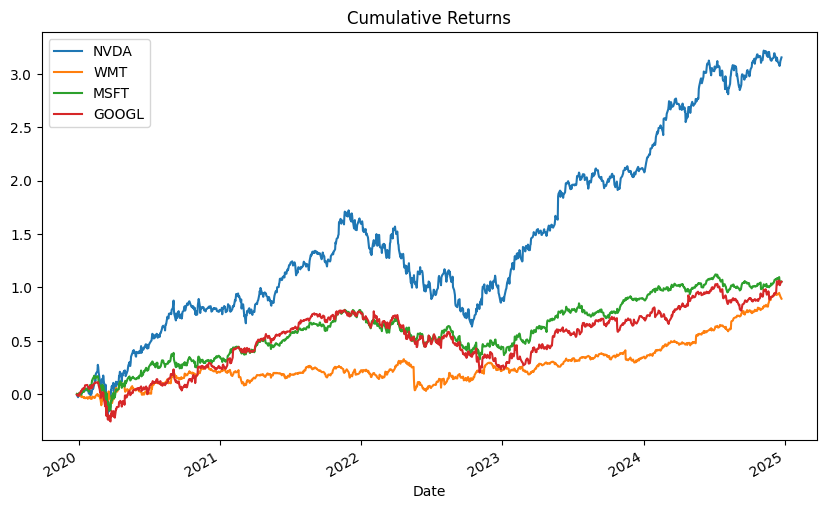

In [153]:
cumulative_returns.plot(title="Cumulative Returns", figsize=(10, 6))

Calculate Covariance Matrix (Annualized by Multiplying with 252 Trading Days)

In [154]:
cov_matrix = log_returns.cov() * 252
cov_matrix

,NVDA,WMT,MSFT,GOOGL
NVDA,0.286585,0.029753,0.112500,0.104639
WMT,0.029753,0.050839,0.025883,0.021544
MSFT,0.112500,0.025883,0.093182,0.074288
GOOGL,0.104639,0.021544,0.074288,0.105889


Define Portfolio Performance Metrics

In [155]:
#Calculate the Annualized Return Expected
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

#Calculate the Volatility
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

#Calculate the Risk-Adjusted Return (Sharpe Ratio)
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

Portfilio Optimization

In [156]:


risk_free_rate = 0.025

#Negate sharpe ratio enable the use of optimization algorithms that are designed to minimize a function.
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

#Set constraints to ensure the sum of the weights adds upto 1

constraints = {'type' : "eq", 'fun': lambda weights: np.sum(weights) - 1}

#Set bounds to ensure the weight of each assets are within 0 and 1
bounds = [(0, 0.3) for _ in range(len(tickers))]

#Create a list of equal weights for all assets
initial_weights = np.array([1/len(tickers)]*len(tickers))

# Optimize for maximum Sharpe ratio
optimized_results = minimize(neg_sharpe_ratio, 
                          initial_weights, 
                          args=(log_returns, cov_matrix, risk_free_rate), 
                          method='SLSQP', 
                          constraints=constraints, 
                          bounds=bounds)

print("Optimal Portfolio Weights:", optimized_results.x) 

Optimal Portfolio Weights: [0.3        0.3        0.17804302 0.22195698]


Optimal Portfolio Analysis

In [157]:
#optimized_results.x is optimal weight
for ticker, weight in zip(tickers, optimized_results.x):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimized_results.x, log_returns)
optimal_portfolio_volatility = standard_deviation(optimized_results.x, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimized_results.x, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

NVDA: 0.3000
WMT: 0.3000
MSFT: 0.1780
GOOGL: 0.2220
Expected Annual Return: 0.3283
Expected Volatility: 0.2852
Sharpe Ratio: 1.0632


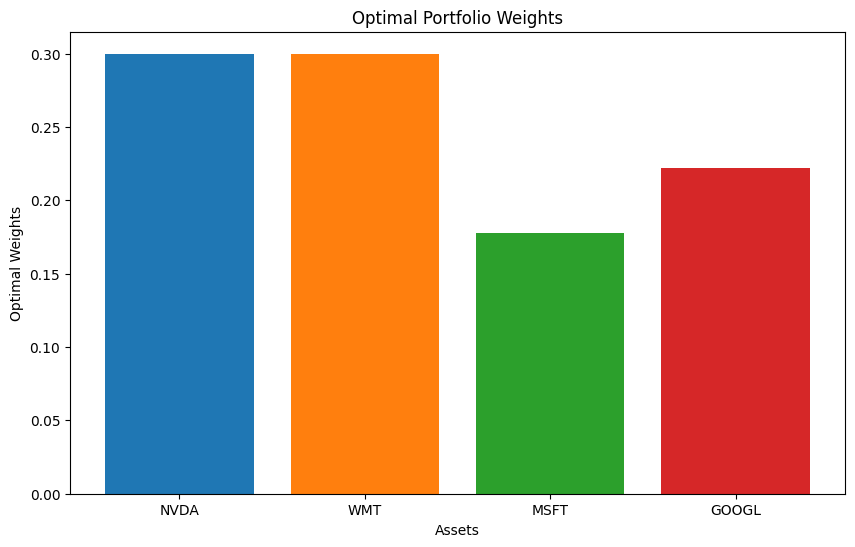

In [158]:
#Assign optimal_weights variable 
optimal_weights = optimized_results.x

#Choose a colormap
cmap = plt.cm.tab10 

#Create an array of colors based on the chosen colormap
colors = cmap(np.arange(len(tickers)) % cmap.N)

#Ploting a bar graph to visualize the portfolio weights
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights, color=colors)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

Monte Carlo Price Simulation

In [171]:
log_returns = np.log(df/df.shift(1))
log_returns = log_returns.dropna()

# Calculate mean and covariance matrix of daily log returns
return_means = log_returns.mean()
cov_matrix = log_returns.cov()

#Define simulation parameters
num_simulations = 1000
simulation_days = 252 # trading days 

# Generate correlated random returns
daily_returns = np.random.multivariate_normal(return_means, cov_matrix, num_simulations)

#Initialize array of simulated prices
simulated_prices = np.zeros((num_simulations, simulation_days, len(tickers)))

#Set initial price for simulation to be the Last closing price
simulated_prices[:, 0, :] = df.iloc[-1].values.reshape(1, 1, -1)

# Simulate prices
for i in range(1, simulation_days):
    simulated_prices[:, i, :] = simulated_prices[:, i - 1, :] * np.exp(daily_returns)
    



ValueError: could not broadcast input array from shape (1,5) into shape (1000,4)

In [ ]:
# Plot simulated price paths
plt.figure(figsize=(10, 6))
plt.plot(simulated_prices)
plt.xlabel('Days')
plt.ylabel('Simulated Price')
plt.title('Monte Carlo Simulation of Apple Stock Price')
plt.show()